In [30]:
import pandas as pd
import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

import lib.draw as draw
from lib.pitch_control import plot_pitch_control
import imageio
import os

In [2]:
df_grids = pd.read_csv('res/grids.csv')
df_grids.head(4)

,play_frame_id,model_name,c0,c1,c2,c3,c4,c5,c6,c7,...,c7304,c7305,c7306,c7307,c7308,c7309,c7310,c7311,c7312,c7313
0,1,KNN (Voronoi),1.00,1.00,1.00,1.00,-1.0,-1.00,-1.00,-1.00,...,1.00,1.00,1.00,1.00,1.00,1.0,1.0,1.00,1.00,1.0
1,1,KNN (Spearman),1.00,0.60,0.33,0.14,0.0,-0.25,-0.50,-0.75,...,1.00,1.00,1.00,1.00,1.00,1.0,1.0,1.00,1.00,1.0
2,1,KNN (Fernandez),0.08,0.07,0.04,0.02,-0.0,-0.03,-0.05,-0.08,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.0
3,1,Spearman Pitch Control,0.68,0.64,0.59,0.55,0.5,0.45,0.40,0.35,...,0.99,0.99,0.99,0.99,0.99,1.0,1.0,0.99,0.99,1.0


In [3]:
df_results = pd.read_csv('res/results.csv')
df_results.head(4)

,play_frame_id,model,play,frame,inference_time
0,1,KNN (Voronoi),Liverpool [2] - 0 Porto,0,0.285072
1,1,KNN (Spearman),Liverpool [2] - 0 Porto,0,0.883843
2,1,KNN (Fernandez),Liverpool [2] - 0 Porto,0,0.803579
3,1,Spearman Pitch Control,Liverpool [2] - 0 Porto,0,21.528398


In [4]:
df_data = pd.read_csv('data/all_goals.csv', low_memory=False)
df_data.edgecolor.fillna('white', inplace=True)
df_data.bgcolor.fillna('black', inplace=True)
df_data.head(4)

,bgcolor,dx,dy,edgecolor,frame,play,player,player_num,team,x,y,z,coords,player_obj,num,name,play_id
0,black,0.000000,0.000000,white,0,Liverpool [3] - 0 Bournemouth,0,NaN,NaN,46.394558,11.134454,0.0,NaN,NaN,NaN,NaN,15
1,black,0.185745,1.217580,white,1,Liverpool [3] - 0 Bournemouth,0,NaN,NaN,46.580302,12.352034,0.0,NaN,NaN,NaN,NaN,15
2,black,0.178659,1.171133,white,2,Liverpool [3] - 0 Bournemouth,0,NaN,NaN,46.758961,13.523166,0.0,NaN,NaN,NaN,NaN,15
3,black,0.171573,1.124685,white,3,Liverpool [3] - 0 Bournemouth,0,NaN,NaN,46.930535,14.647852,0.0,NaN,NaN,NaN,NaN,15


In [5]:
def generate_gif(grids, results, player_data, play_name, model_name):
    _grids = grids[(grids.model_name == model_name) & grids.play_frame_id.isin(results[results.play == play_name].play_frame_id)]
    grid = pd.DataFrame([[i/1.05, j/0.68] for i in range(106) for j in range(69)], columns=['x','y'])
    temp_file_name = '_tmp/104.png'

    writer = imageio.get_writer(f'img/{model_name}_{play_name}.gif', mode='I')
    for original_frame_no, frame_no in tqdm(enumerate(_grids.play_frame_id.unique()), total=len(_grids.play_frame_id.unique())):
        _frame = _grids[_grids.play_frame_id == frame_no]
        original_frame = player_data[(player_data.frame == original_frame_no) & (player_data.play == play_name)]
        plot_pitch_control(original_frame, grid, _frame.iloc[:, 2:].to_numpy(), modelname=model_name, savefig=temp_file_name)
        image = imageio.imread(temp_file_name)
        writer.append_data(image)
    writer.close()

In [6]:
for i, row in df_results[['model', 'play']].drop_duplicates().iterrows():
    if os.path.isfile(f'img/{row.model}_{row.play}.gif') == False:
        generate_gif(df_grids, df_results, df_data, row.play, row.model)

In [36]:
def plot_pitch_control_b(frame, grid, control, modelname=None, title=None, dpi=120, subplot=None, savefig=None):
    '''
    Description
    -------
    Plots the pitch control visualization using the scatter function

    Parameters
    -------
        frame: a dataframe containing the positions x, y of all players and the ball, and both bgcolor and edgecolor
        grid: a dataframe containing the coordinates x, y used to generate the pitch control vector
        control: a series containing the values of control for each coordinate in the grid
        modelname: text to write in the figure
        dpi: adjust image dpi
        subplot: use to plot only in one subplot. None to ignore.
        savefig: use to give a directory to save the figure. None to ignore.

    Returns
    -------
        None
    '''

    # Add subplot if requested
    if subplot != None:
        plt.subplot(subplot)

    # Drawing background
    draw.pitch(dpi=dpi)

    # Plotting pitch control
    #plt.scatter(grid.x, grid.y, s=20, marker='s', c=control, cmap='seismic', alpha=0.2)
    #plt.clim(control.min(), control.max())
    plt.imshow(np.rot90(control.reshape((106,69))), extent=(0, 100, 0, 100),interpolation='spline36',vmin=0.0,vmax=1.0,cmap='seismic',alpha=0.5, zorder=2)
    
    # Plotting the elements of both teams
    plt.scatter(frame.x, frame.y, s=100, c=frame.bgcolor.values, edgecolors=frame.edgecolor, zorder=10)
    _ball = frame[frame.player == 0]
    plt.scatter(_ball.x, _ball.y, s=50, c=_ball.bgcolor.values, edgecolors=_ball.edgecolor, zorder=11)


    # Writing name of the model on the figure
    if modelname != None:
        plt.text(1, 1, modelname, fontsize='xx-large',
            path_effects=[pe.withStroke(linewidth=2, foreground="white")])
    
    # Writing a title
    if title != None:
        plt.text(1, 99, title, fontsize='xx-large', va='top',
            path_effects=[pe.withStroke(linewidth=2, foreground="white")])


    # End clauses to:
    ## Save figure in a directory
    if savefig != None:
        plt.savefig(savefig, bbox_inches='tight')
        plt.clf()
    ## Wait for the remaining subplots
    elif subplot != None:
        return
    ## Plot the figure
    else:
        plt.show()

def run_pc(grids, results, player_data, play_name, model_name):
    _grids = grids[(grids.model_name == model_name) & grids.play_frame_id.isin(results[results.play == play_name].play_frame_id)]
    grid = pd.DataFrame([[i/1.05, j/0.68] for i in range(106) for j in range(69)], columns=['x','y'])
    for original_frame_no, frame_no in tqdm(enumerate(_grids.play_frame_id.unique()), total=len(_grids.play_frame_id.unique())):
        _frame = _grids[_grids.play_frame_id == frame_no]
        original_frame = player_data[(player_data.frame == original_frame_no) & (player_data.play == play_name)]
        plot_pitch_control_b(original_frame, grid, _frame.iloc[:, 2:].to_numpy(), modelname=model_name)
        break

  0%|          | 0/289 [00:00<?, ?it/s]

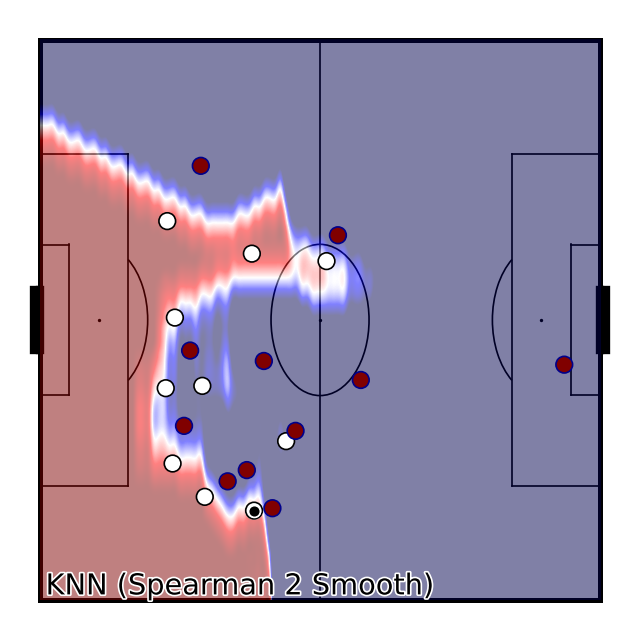

  0%|          | 0/289 [00:00<?, ?it/s]


In [37]:
run_pc(df_grids, df_results, df_data, row.play, row.model)